# LOESS

Parameters:
- df (pd.DataFrame): DataFrame indexed by datetime with pollution data.
- column (str): The column name of the pollutant (e.g. 'pm25').
- frac (float): LOESS smoothing fraction (window size).
- threshold_std (float): Number of std devs to define anomaly region.

In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def read_and_clean(filepath):
    df = pd.read_csv(filepath, skipinitialspace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Convert all columns (except date) to numeric
    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by date
    df = df.sort_values(by='date').reset_index(drop=True)

    return df

# Plots LOESS smoothed data with anomaly bands for a given pollutant column.
def plot_loess_with_anomalies(df, column, frac=0.05, threshold_std=2):
    # Drop missing values for selected pollutant
    clean_data = df.dropna(subset=[column])

    # Apply LOESS smoothing
    smoothed = sm.nonparametric.lowess(clean_data[column], clean_data.index, frac=frac)

    # Extract fitted values and compute residuals
    fitted = smoothed[:, 1]
    residuals = clean_data[column].values - fitted
    std = np.std(residuals)

    # Upper and lower thresholds
    upper = fitted + threshold_std * std
    lower = fitted - threshold_std * std

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column], label=f'{column.upper()}', alpha=0.4)
    plt.plot(smoothed[:, 0], fitted, label='LOESS Smoothed', color='red')

    # Shaded anomaly band
    plt.fill_between(smoothed[:, 0], lower, upper, color='red', alpha=0.2, label=f'±{threshold_std}σ Band')

    plt.title(f'LOESS Smoothing with Anomaly Band: {column.upper()}')
    plt.xlabel('Date')
    plt.ylabel(column.upper())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

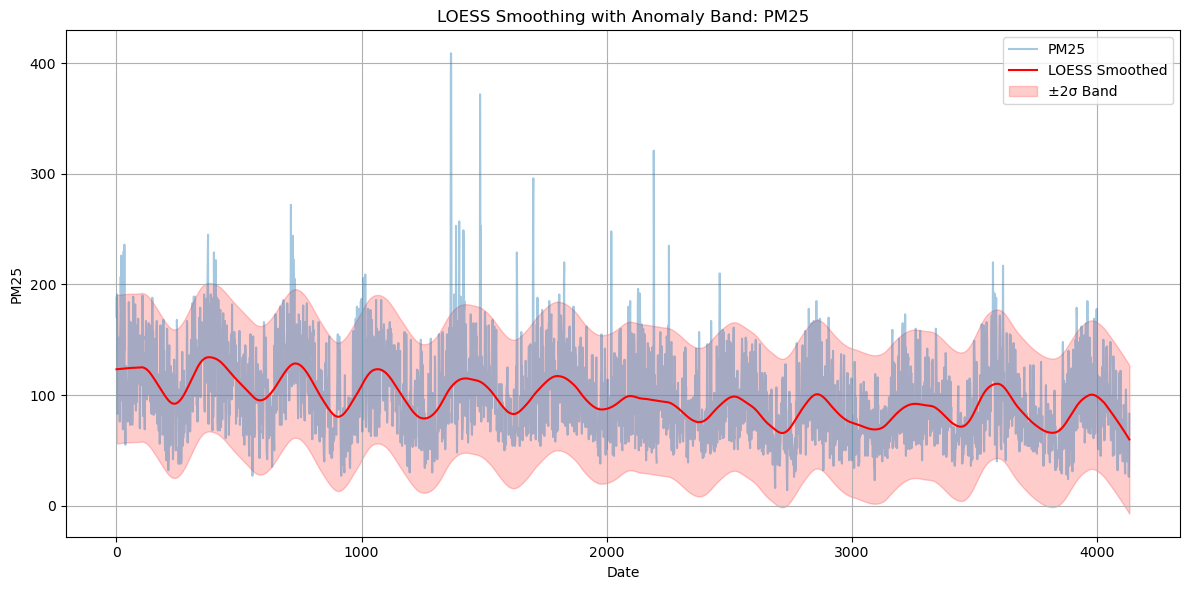

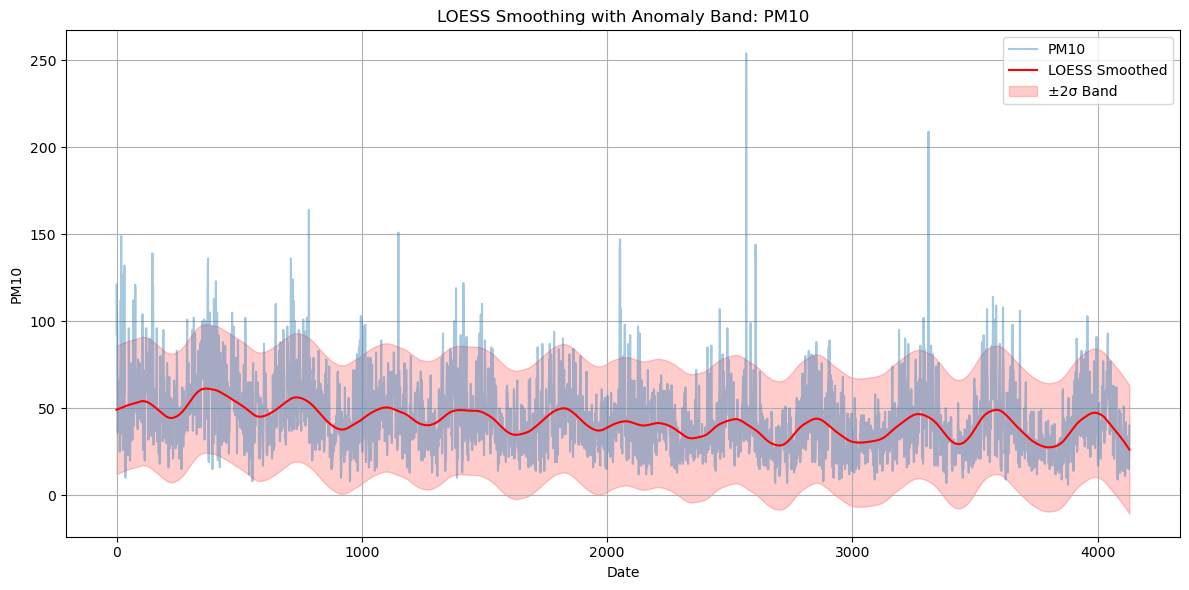

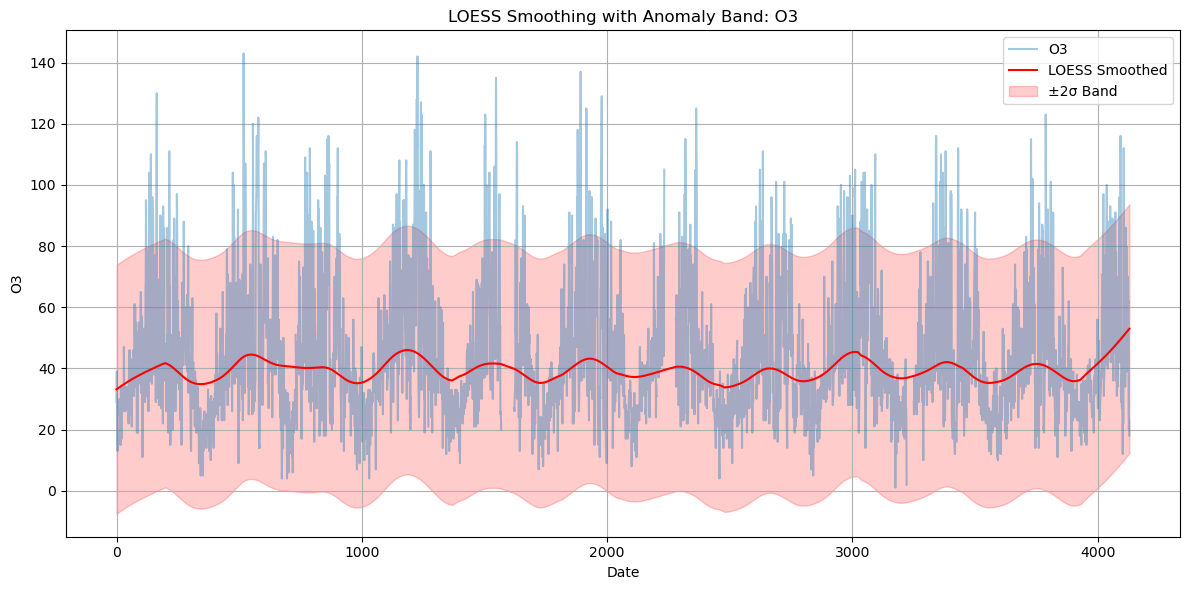

In [2]:
pollution_df = read_and_clean('aqicn_data/shanghai.csv')

# Example usage
plot_loess_with_anomalies(pollution_df, 'pm25')
plot_loess_with_anomalies(pollution_df, 'pm10')
plot_loess_with_anomalies(pollution_df, 'o3', frac=0.1)